# Electrode Microwave Region 4 Rods - 2 rods

**Maxwell file**
```
Electric Field Rods Field Shaping Optimization - 4 Rods 2 Rods
```

![drawing](4rods2rods_drawing.PNG)

simulate potential and electric field for the configuration shown in the figure.  
The separation between left and right electrodes was varied as was the positioning of **R1** and **SEP1** and the voltage on SEP1, **Vsep**.   
The electric field inhomogeneity in the center rectangle was used as the cost function for minimization.

The microwaves are in the 10s GHz range, so I took a minimum separation beteween electrode rods of 3 cm, corresponding to 100 GHz.

  * the top and bottom electrode rods are at $\pm$70 mm
  * electrode rods at $\pm$1000 V
  * center rods at 0 V
  * rod radius = 1 mm
  * boundary conditions are 0 V at $\infty$  
  
Need to redo simulation when shape of vacuum vessel is known, brings ground much closer to beamline.

In [1]:
def set_fontsize(ax, fs):
    """
    Function to set font sizes for axes objects
    """
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs)
    ax.xaxis.label.set_size(fs)
    ax.yaxis.label.set_size(fs)
    ax.title.set_size(fs)

## Parametric Sweep

In [2]:
from scipy.interpolate import griddata
import numpy as np
def generate_gridded_interpolate(x, y, data, method = 'cubic'):
    xi = np.linspace(x.min(), x.max(), 101)
    yi = np.linspace(y.min(), y.max(), 101)
    xx, yy = np.meshgrid(xi, yi)
    return xx, yy, griddata((x,y), data, xi = (xx,yy), method = method)


def string_to_num(df, colname, remove = False):
    if not remove:
        df[colname] = pd.to_numeric(df[colname]) 
    else:
        df[colname] = [float(val.strip(remove)) for val in df[colname].values]

In [3]:
import pandas as pd

data_dir = '../Data/Ansys/'

df_para = pd.read_csv(data_dir+'ParametricSetup1_Result_4rods2rods.csv')
string_to_num(df_para, '$R1', remove = 'mm')
string_to_num(df_para, '$SEP', remove = 'mm')
string_to_num(df_para, '$SEP1', remove = 'mm')
string_to_num(df_para, '$Vsep', remove = 'V')
df_para = df_para.rename(columns = {'fmin: None':'Cost'})
df_para.head()

,Variation,$R1,$SEP,$SEP1,$Vsep,Cost
0,1,25.0,45.0,25.0,200.0,0.018096
1,2,25.0,45.0,25.0,300.0,0.020343
2,3,25.0,45.0,25.0,400.0,0.022556
3,4,25.0,45.0,25.0,500.0,0.024716
4,5,25.0,45.0,25.0,600.0,0.028111


In [4]:
grouped = df_para.groupby('$Vsep')
groups = grouped.groups

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def run_heatmap(voltage):
    idg = groups[voltage]
    df_group = df_para.iloc[idg]
    groups_sep1 = df_group.groupby('$SEP1').groups
    
    fig, axes = plt.subplots(figsize = (15,15), nrows=  2, ncols = 2)
    cnt = 0
    for idk, key in enumerate(groups_sep1.keys()):
        if (idk%2 == 0) and (idk > 0):
            cnt += 1
        ax = axes[cnt,idk%2]
        df_group_sep1 = df_group.loc[groups_sep1[key]]
        xx, yy, cost = generate_gridded_interpolate(df_group_sep1['$R1'].values, 
                                                    df_group_sep1['$SEP'].values, 
                                                    df_group_sep1['Cost'].values)
        pc = ax.pcolormesh(xx, yy, 100*cost)
        ax.contour(xx,yy,cost, 30, colors = 'k')
        ax.set_xlabel('R1 [mm]')
        ax.set_ylabel('separation [mm]');
        ax.set_title('Parametric Sweep; $SEP1 = {0} mm'.format(key))
        set_fontsize(ax, 15)

        R1 = df_group.loc[df_group_sep1.Cost.idxmin()]['$R1']
        sep = df_group.loc[df_group_sep1.Cost.idxmin()]['$SEP']
        ax.plot(R1, sep, '.', ms = 30, color = 'C3')

        cbar = fig.colorbar(pc, ax = ax);
        cbar.set_label('% inhomogeneity', fontsize = 15)
        cbar.ax.tick_params(labelsize=15);

In [6]:
df_sorted = df_para.sort_values('Cost')

In [7]:
df_sorted.iloc[:10]

,Variation,$R1,$SEP,$SEP1,$Vsep,Cost
145,146,25.0,75.0,25.0,300.0,0.000235
158,159,25.0,75.0,35.0,400.0,0.000244
121,122,25.0,70.0,25.0,300.0,0.000613
134,135,25.0,70.0,35.0,400.0,0.000706
97,98,25.0,65.0,25.0,300.0,0.000874
110,111,25.0,65.0,35.0,400.0,0.001204
499,500,35.0,75.0,40.0,300.0,0.001564
301,302,30.0,70.0,35.0,300.0,0.001637
319,320,30.0,75.0,30.0,300.0,0.001709
86,87,25.0,60.0,35.0,400.0,0.001742


In [8]:
from ipywidgets import interact, widgets
interact(run_heatmap, voltage = widgets.IntSlider(min = 200, max = 700,
                                                step = 100, value = 500));

interactive(children=(IntSlider(value=500, description='voltage', max=700, min=200, step=100), Output()), _dom…

## Optimization

In [9]:
df_opt = pd.read_csv(data_dir+'OptimizationSetup1_Result_4rods2rods.csv')
string_to_num(df_opt, '$R1', remove = 'mm')
string_to_num(df_opt, '$SEP', remove = 'mm')
string_to_num(df_opt, '$SEP1', remove = 'mm')
string_to_num(df_opt, '$Vsep', remove = 'V')

In [10]:
df_sorted = df_opt.sort_values('Cost')
df_sorted.head(10)

,Evaluation,$R1,$SEP,$SEP1,$Vsep,Cost
182,183,24.000000,73.359410,29.206504,365.525548,1.515100e-09
191,192,24.000000,73.378775,29.205089,365.434668,1.565400e-09
190,191,24.000000,73.465258,29.198771,365.028790,2.034700e-09
177,178,24.000000,73.573909,29.189947,364.720707,2.142700e-09
174,175,24.014150,73.573909,29.189947,364.418181,2.224400e-09
175,176,24.000000,73.671777,29.189947,364.418181,2.317700e-09
179,180,24.000000,73.573909,29.156228,364.418181,2.375600e-09
183,184,24.015132,73.359410,29.206504,365.525548,2.401200e-09
185,186,24.000000,73.359410,29.240527,365.525548,2.587100e-09
181,182,24.000000,73.159129,29.221964,366.559516,2.787400e-09


In [11]:
def calculate_aspect(x,y):
    return (y.ptp()/x.ptp())/(np.unique(y).size/np.unique(x).size)

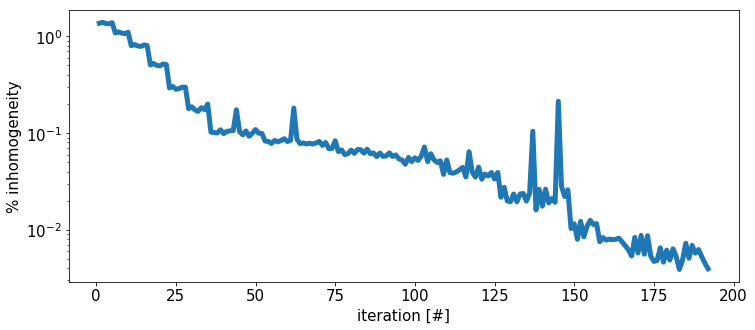

In [12]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(df_opt.Evaluation, np.sqrt(df_opt.Cost)*100, lw = 5)
set_fontsize(ax, 15)
ax.locator_params(axis = 'y', nbins = 5)
ax.set_xlabel('iteration [#]')
ax.set_yscale('log')
ax.set_ylabel('% inhomogeneity');

Parameters for which the inhomogeneity is minimized

In [13]:
df_opt.iloc[df_opt.Cost.idxmin()]

Evaluation    1.830000e+02
$R1           2.400000e+01
$SEP          7.335941e+01
$SEP1         2.920650e+01
$Vsep         3.655255e+02
Cost          1.515100e-09
Name: 182, dtype: float64

so **R1** at 24 mm, **SEP** at 73.36 mm, **SEP1** at 29.21 mm and **Vsep** at 365.5 V gives the best homogeneity

## Loading the potential

In [14]:
def load_fld_potential(fname, data_dir = data_dir):
    names = ['x', 'y', 'z', 'V']
    df = pd.read_csv(data_dir+fname, skiprows = 2, header = None, delim_whitespace = True,
                     names = names)
    return df

In [15]:
potential = load_fld_potential('potential_4rods2rods.fld')

In [16]:
potential.head()

,x,y,z,V
0,-0.07,-0.08000,0.0,-623.067367
1,-0.07,-0.07975,0.0,-627.085717
2,-0.07,-0.07950,0.0,-631.182044
3,-0.07,-0.07925,0.0,-635.356350
4,-0.07,-0.07900,0.0,-639.608633


## Plotting Potential

In [17]:
def calculate_aspect(x,y):
    return (y.ptp()/x.ptp())/(np.unique(y).size/np.unique(x).size)

In [18]:
def generate_gridded(x, y, data):
    xx, yy = np.meshgrid(np.unique(x), np.unique(y))
    x_vals, x_ind = np.unique(x, return_inverse = True)
    y_vals, y_ind = np.unique(y, return_inverse = True)
    data_array = np.empty(x_vals.shape + y_vals.shape)
    data_array.fill(np.nan)
    data_array[x_ind, y_ind] = data
    return xx, yy, data_array.T

In [19]:
xx, yy, potential_array = generate_gridded(potential.x, 
                                           potential.y, 
                                           potential.V)

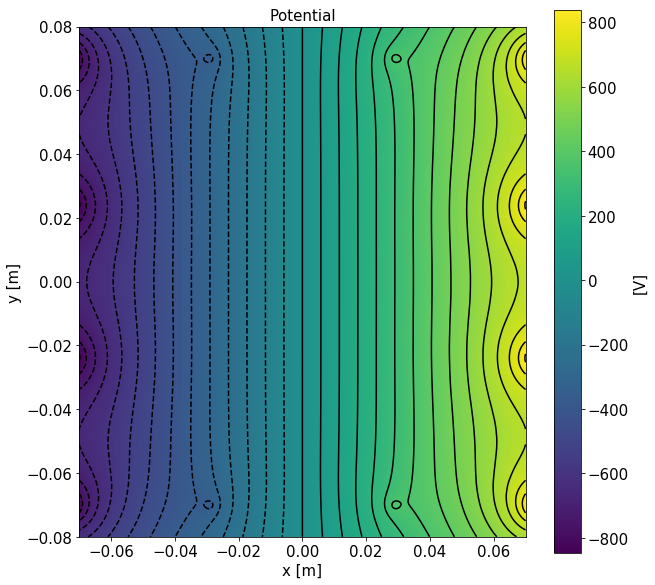

In [20]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect(calculate_aspect(xx,yy))
pc = ax.pcolormesh(xx, yy, potential_array)
ax.contour(xx,yy,potential_array, 30, colors = 'k')
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Potential')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[V]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

In [21]:
xc, yc = np.array(xx.shape)//2

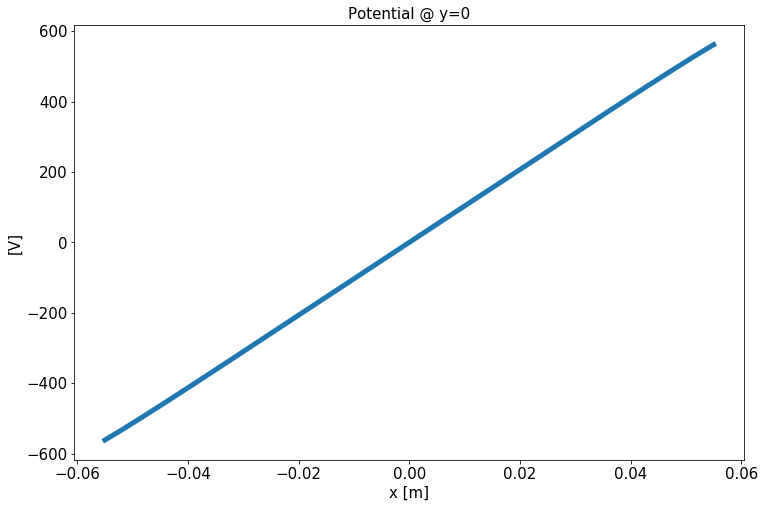

In [22]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_title(r'Potential @ y=0')
ax.plot(xx[xc,60:-60], potential_array[xc,60:-60], lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('x [m]')
ax.set_ylabel('[V]');

## Loading Electric Field

In [23]:
def load_fld_field(fname, data_dir = data_dir):
    names = ['x', 'y', 'z', 'Ex', 'Ey', 'Ez']
    df = pd.read_csv(data_dir+fname, skiprows = 2, header = None, 
                     delim_whitespace = True, names = names)
    return df

In [24]:
field = load_fld_field('field_4rods2rods.fld')

In [25]:
field.head()

,x,y,z,Ex,Ey,Ez
0,-0.07,-0.08000,0.0,-6738.501533,15955.743810,0.0
1,-0.07,-0.07975,0.0,-6936.214174,16279.029264,0.0
2,-0.07,-0.07950,0.0,-7143.325033,16590.105445,0.0
3,-0.07,-0.07925,0.0,-7359.834110,16888.972353,0.0
4,-0.07,-0.07900,0.0,-7585.741406,17175.629986,0.0


## Generating Gridded Field

In [26]:
xx, yy, Ex = generate_gridded(field.x.values, 
                              field.y.values, 
                              field.Ex.values)
_, _, Ey = generate_gridded(field.x.values, 
                            field.y.values, 
                            field.Ey.values)
Emag = np.sqrt(Ex**2+Ey**2)

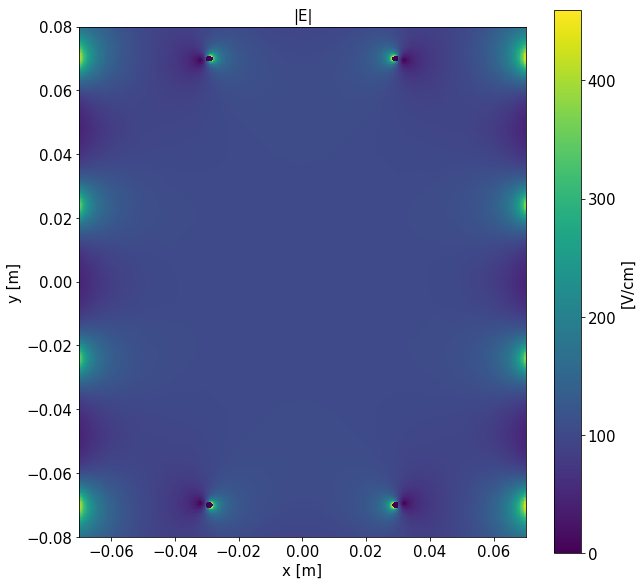

In [27]:
fig, ax = plt.subplots(figsize = (10,10))
ax.set_aspect(calculate_aspect(xx,yy))
pc = ax.pcolormesh(xx, yy, Emag/100)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('|E|')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[V/cm]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

In [28]:
xc, yc = np.array(xx.shape)//2

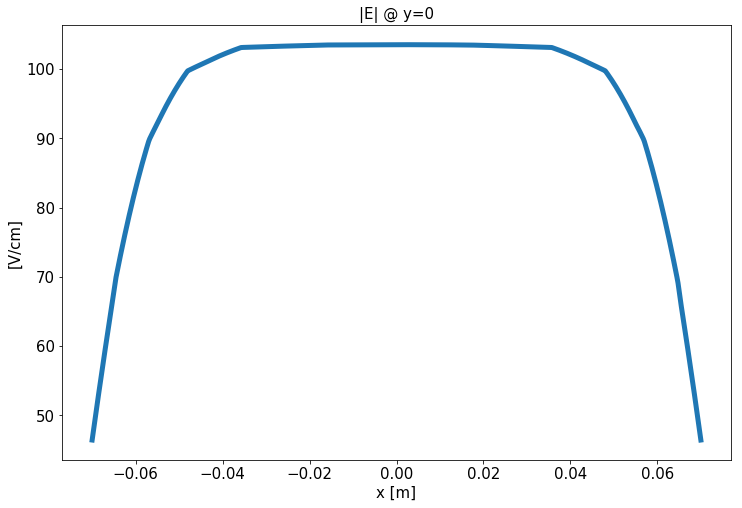

In [29]:
fig, ax = plt.subplots(figsize = (12,8))
ax.set_title(r'|E| @ y=0')
ax.plot(xx[xc,:], Emag[xc,:]/100, lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('x [m]')
ax.set_ylabel('[V/cm]');

## Zooming to beam region

In [30]:
potential_center = load_fld_potential('potential_4rods2rods_center.fld')
field_center = load_fld_field('field_4rods2rods_center.fld')

In [31]:
xx, yy, potential_array = generate_gridded(potential_center.x, 
                                           potential_center.y, 
                                           potential_center.V)

In [32]:
xx, yy, Ex = generate_gridded(field_center.x.values, 
                              field_center.y.values, 
                              field_center.Ex.values)
_, _, Ey = generate_gridded(field_center.x.values, 
                            field_center.y.values, 
                            field_center.Ey.values)
Emag = np.sqrt(Ex**2+Ey**2)

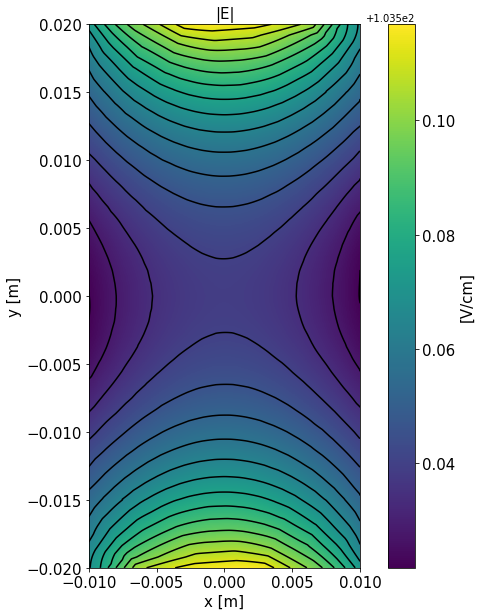

In [33]:
fig, ax = plt.subplots(figsize = (10,10))
pc = ax.pcolormesh(xx, yy, Emag/100)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect(calculate_aspect(xx,yy))
ax.contour(xx,yy,Emag, 15, colors = 'k')
ax.locator_params(axis='x', nbins = 4)
ax.set_title('|E|')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[V/cm]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

it seems most of the inhomogeneity comes from the two electrode rods on the left and right side at y=0.

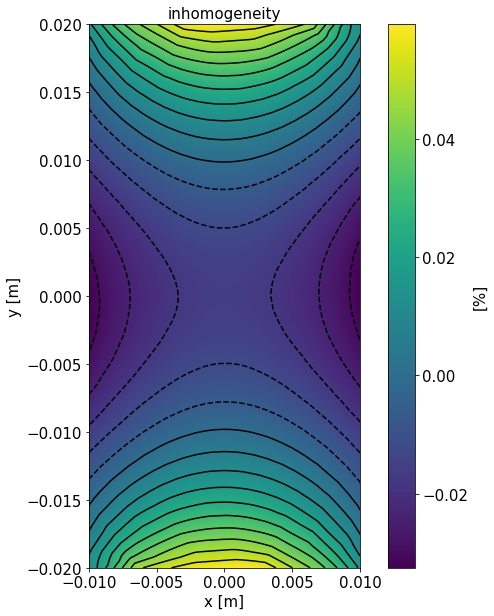

In [34]:
inhomogeneity = 100*(Emag-Emag.mean())/Emag.mean()
fig, ax = plt.subplots(figsize = (10,10))
pc = ax.pcolormesh(xx, yy, inhomogeneity)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect(calculate_aspect(xx,yy))
ax.contour(xx,yy,inhomogeneity, 15, colors = 'k')
ax.locator_params(axis='x', nbins = 4)
ax.set_title('inhomogeneity')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[%]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

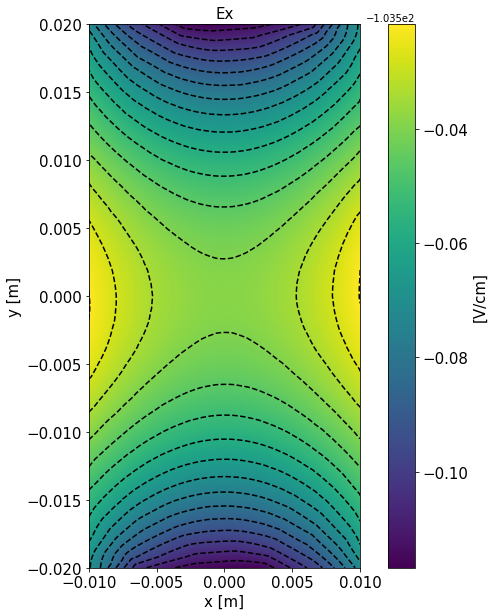

In [35]:
fig, ax = plt.subplots(figsize = (10,10))
pc = ax.pcolormesh(xx, yy, Ex/100)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect(calculate_aspect(xx,yy))
ax.contour(xx,yy,Ex, 15, colors = 'k')
ax.locator_params(axis='x', nbins = 4)
ax.set_title('Ex')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[V/cm]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

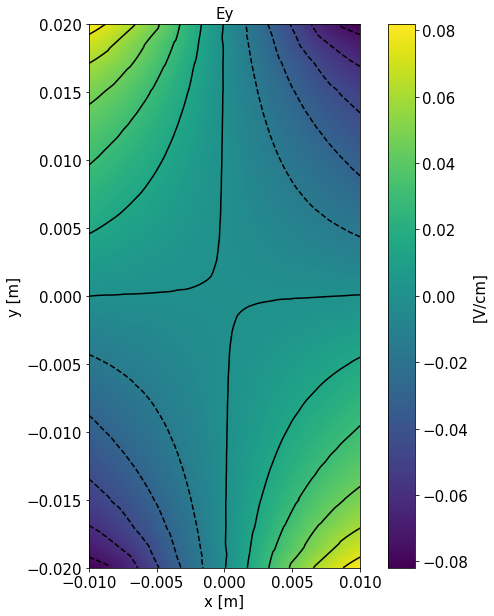

In [36]:
fig, ax = plt.subplots(figsize = (10,10))
pc = ax.pcolormesh(xx, yy, Ey/100)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_aspect(calculate_aspect(xx,yy))
ax.contour(xx,yy,Ey, 15, colors = 'k')
ax.locator_params(axis='x', nbins = 4)
ax.set_title('Ey')
set_fontsize(ax, 15)

cbar = fig.colorbar(pc);
cbar.set_label('[V/cm]', fontsize = 15)
cbar.ax.tick_params(labelsize=15)

In [37]:
xc, yc = np.array(xx.shape)//2

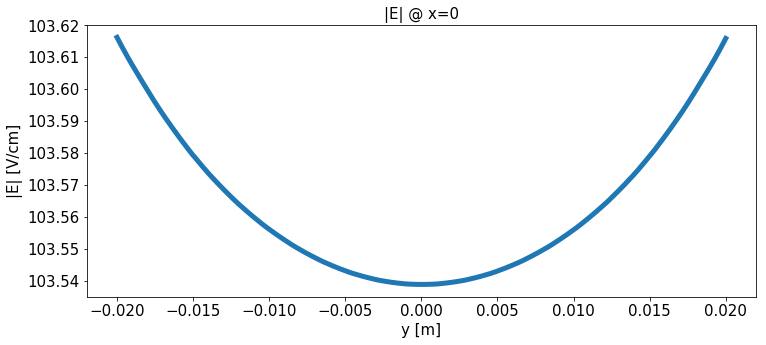

In [38]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_title(r'|E| @ x=0')
ax.plot(yy[:,yc], Emag[:,yc]/100, lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('y [m]')
ax.set_ylabel('|E| [V/cm]');

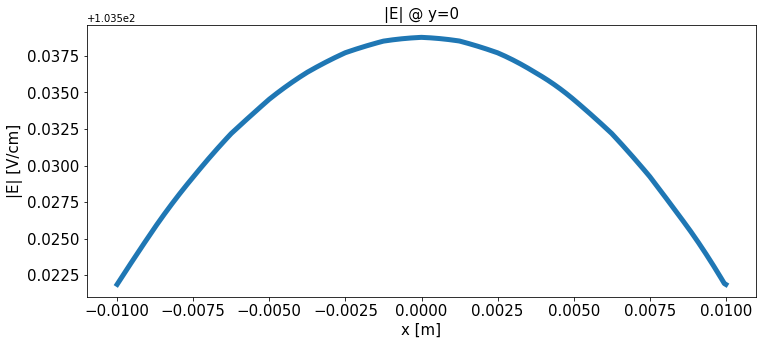

In [39]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_title(r'|E| @ y=0')
ax.plot(xx[xc,:], Emag[xc,:]/100, lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('x [m]')
ax.set_ylabel('|E| [V/cm]');

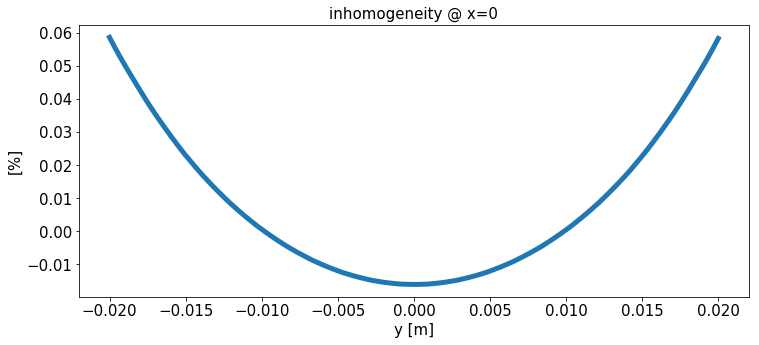

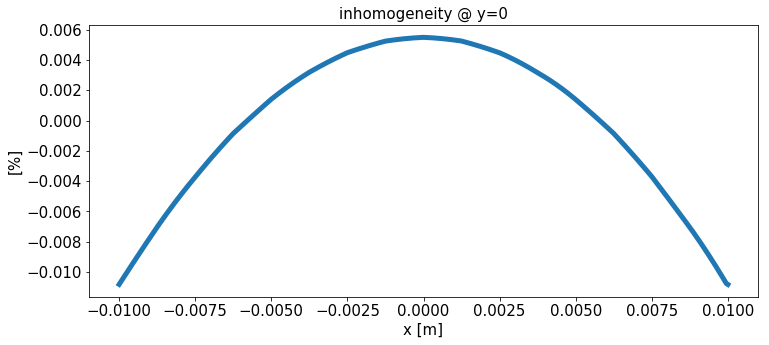

In [40]:
fig, ax = plt.subplots(figsize = (12,5))
ax.set_title(r'inhomogeneity @ x=0')
ax.plot(yy[:,yc], 100*(Emag[:,yc]-Emag.mean())/(Emag.mean()), lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('y [m]')
ax.set_ylabel('[%]');

fig, ax = plt.subplots(figsize = (12,5))
ax.set_title(r'inhomogeneity @ y=0')
ax.plot(xx[xc,:], 100*(Emag[xc,:]-Emag[xc,:].mean())/(Emag[xc,:]), lw = 5)
set_fontsize(ax, 15)
ax.set_xlabel('x [m]')
ax.set_ylabel('[%]');